# Housing Regression Maching Learning Project

### Imports (Data and Packages)

In [256]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="white")
%matplotlib inline 

In [257]:
housing = pd.read_csv('./data/Ames_Housing_Price_Data.csv', index_col=0)
real_estate = pd.read_csv('./data/Ames_Real_Estate_data.csv' , index_col = 0)

C:\Users\jackc\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (36,40,81,87) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Beginning to Clean Data and Handle Null Values

In [258]:
## Checking for null values
columns_with_nulls = {}
for column in housing.columns:
    if(housing[column].isnull().sum() > 0):
        columns_with_nulls[column] = housing[column].isnull().sum()

## Set a threshold for how many values will be allowed per column 
threshold = 500

## Remove columns that have more null values than the threshold allows
## For columns that have nulls, but less than the threshold, put in list to fill the nulls later
cols_to_remove = []
cols_to_fill = []
[cols_to_remove.append(k) if v>=threshold else cols_to_fill.append(k) for k,v in columns_with_nulls.items()]
housing.drop(cols_to_remove, axis = 1, inplace = True)

## Print which columns were removed to ensure that there is nothing important that was removed 
print("A total of %s columns were removed from the dataset. The following columns were removed from the housing dataset: " %len(cols_to_remove) )
for col in cols_to_remove:
    print(col)

print('-'*120)

## Look at Null values for other columns and see how to fill
for col in cols_to_fill:
    print(col , ' ' , housing[col].isnull().sum(),' ', housing[col].dtype)

## For now, remove all nulls by row 
housing.dropna(axis = 0, inplace = True)


A total of 5 columns were removed from the dataset. The following columns were removed from the housing dataset: 
Alley
FireplaceQu
PoolQC
Fence
MiscFeature
------------------------------------------------------------------------------------------------------------------------
LotFrontage   462   float64
MasVnrType   14   object
MasVnrArea   14   float64
BsmtQual   69   object
BsmtCond   69   object
BsmtExposure   71   object
BsmtFinType1   69   object
BsmtFinSF1   1   float64
BsmtFinType2   70   object
BsmtFinSF2   1   float64
BsmtUnfSF   1   float64
TotalBsmtSF   1   float64
Electrical   1   object
BsmtFullBath   2   float64
BsmtHalfBath   2   float64
GarageType   127   object
GarageYrBlt   129   float64
GarageFinish   129   object
GarageCars   1   float64
GarageArea   1   float64
GarageQual   129   object
GarageCond   129   object


### EDA

<AxesSubplot:>

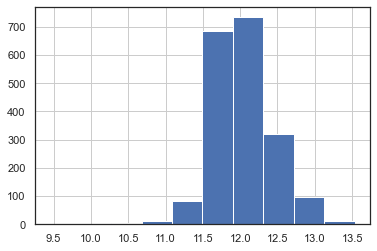

In [259]:
## First looking at Sale Price to see the features
np.log(housing['SalePrice']).hist()

## Histogram looks skewed right - is this going to be a problem? Maybe try a boxcox transformation or log? 

In [260]:
## See correlations related to sale price and to eyeball which features might matter the most 
corrs = housing.corr()
highly_correlated = corrs[np.abs(corrs['SalePrice']) >= .6]
medium_correlated = corrs[np.abs(corrs['SalePrice']).between(.4,.6)] 
low_correlated = corrs[(np.abs(corrs['SalePrice']) < .4)] 

## Print out column headers that are going to have high and medium correlations to sales price 
print('Highly correlated variables are: ')
print(highly_correlated['SalePrice'])
print('-'*150)
print('Medium correlated variables are: ')
print(medium_correlated['SalePrice'])

Highly correlated variables are: 
GrLivArea      0.725921
SalePrice      1.000000
OverallQual    0.795455
TotalBsmtSF    0.684205
1stFlrSF       0.678018
GarageCars     0.657739
GarageArea     0.650319
Name: SalePrice, dtype: float64
------------------------------------------------------------------------------------------------------------------------------------------------------
Medium correlated variables are: 
YearBuilt       0.543807
YearRemodAdd    0.514073
MasVnrArea      0.517313
BsmtFinSF1      0.463311
FullBath        0.549002
TotRmsAbvGrd    0.516318
Fireplaces      0.473911
GarageYrBlt     0.529246
Name: SalePrice, dtype: float64


In [265]:
#Messing around with regression just to see

from sklearn.linear_model import LinearRegression

target = housing['SalePrice']
housing.drop(['SalePrice'] , axis =1, inplace = True)
for_model = housing[['GrLivArea', 'OverallQual', 'TotalBsmtSF' , '1stFlrSF' , 'GarageCars', 'GarageArea']]


lm = LinearRegression()
lm.fit(for_model, np.log(target))
lm.score(for_model, np.log(target))


0.8211859261626148